1.скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
2.сделать разбиение набора данных не тренировочную и тестовую выборки
3.сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
4.провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
5.в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [18]:
import numpy as np
import pandas as pd

In [19]:
df = pd.read_csv('data.csv', sep=',')

In [20]:
df.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [21]:
df.rename({'offer': 'treatment', 'conversion': 'target'}, axis=1, inplace=True)
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [22]:
df['treatment'] = df['treatment'].apply(lambda x: 1 if x == 'Buy One Get One' else 0)
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,0,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,0,0
63996,5,38.91,0,1,Urban,1,Phone,0,0
63997,6,29.99,1,0,Urban,1,Phone,0,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


In [42]:
df['treatment'].dtype

dtype('int64')

In [23]:
df.describe()

,recency,history,used_discount,used_bogo,is_referral,treatment,target
count,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000,64000.000000
mean,5.763734,242.085656,0.551031,0.549719,0.502250,0.334172,0.146781
std,3.507592,256.158608,0.497393,0.497526,0.499999,0.471704,0.353890
min,1.000000,29.990000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,64.660000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.000000,158.110000,1.000000,1.000000,1.000000,0.000000,0.000000
75%,9.000000,325.657500,1.000000,1.000000,1.000000,1.000000,0.000000
max,12.000000,3345.930000,1.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


In [25]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [26]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

In [10]:
##df = pd.concat([df.drop(columns='channel', axis=1), pd.get_dummies(df['channel'], prefix='channel')], 1)
##df

C:\Users\C559~1\AppData\Local\Temp/ipykernel_7224/2782648127.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([df.drop(columns='channel', axis=1), pd.get_dummies(df['channel'], prefix='channel')], 1)


,recency,history,used_discount,used_bogo,zip_code,is_referral,treatment,target,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,Surburban,0,1,0,0,1,0
1,6,329.08,1,1,Rural,1,0,0,0,0,1
2,7,180.65,0,1,Surburban,1,1,0,0,0,1
3,9,675.83,1,0,Rural,1,0,0,0,0,1
4,2,45.34,1,0,Urban,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,0,0,0,0,1
63996,5,38.91,0,1,Urban,1,0,0,0,1,0
63997,6,29.99,1,0,Urban,1,0,0,0,1,0
63998,1,552.94,1,0,Surburban,1,1,0,1,0,0


In [11]:
##df = pd.concat([df.drop(columns='zip_code', axis=1), pd.get_dummies(df['zip_code'], prefix='zip_code')], 1)
##df

C:\Users\C559~1\AppData\Local\Temp/ipykernel_7224/856626569.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([df.drop(columns='zip_code', axis=1), pd.get_dummies(df['zip_code'], prefix='zip_code')], 1)


,recency,history,used_discount,used_bogo,is_referral,treatment,target,channel_Multichannel,channel_Phone,channel_Web,zip_code_Rural,zip_code_Surburban,zip_code_Urban
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,0,0,1,1,0,0
2,7,180.65,0,1,1,1,0,0,0,1,0,1,0
3,9,675.83,1,0,1,0,0,0,0,1,1,0,0
4,2,45.34,1,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,0,0,0,0,0,1,0,0,1
63996,5,38.91,0,1,1,0,0,0,1,0,0,0,1
63997,6,29.99,1,0,1,0,0,0,1,0,0,0,1
63998,1,552.94,1,0,1,1,0,1,0,0,0,1,0


In [27]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

In [28]:
X = df.drop(columns='target')
y = df['target']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape, y_train.shape

((51200, 8), (12800, 8), (51200,))

In [35]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']
treat_train.shape, treat_test.shape

((51200,), (12800,))

In [31]:
cat_features = ['zip_code', 'channel']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}


array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

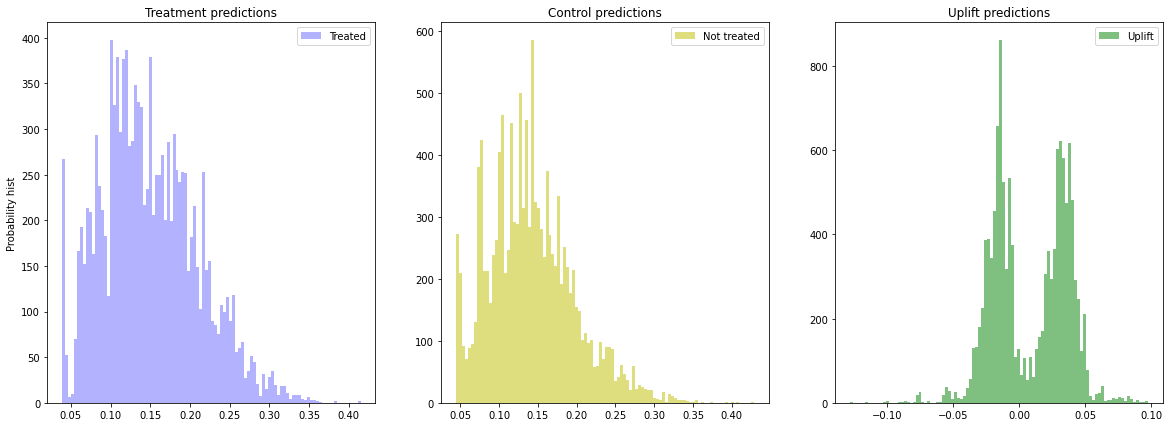

In [32]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)




# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds)

In [65]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,25.118111
1,used_bogo,15.501331
2,channel,11.018425
3,zip_code,10.540216
4,recency,10.521172
5,history,9.819584
6,used_discount,9.335793
7,treatment,8.145367


In [66]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)



array([<AxesSubplot:title={'center':'Treatment predictions'}, ylabel='Probability hist'>,
       <AxesSubplot:title={'center':'Control predictions'}>,
       <AxesSubplot:title={'center':'Uplift predictions'}>], dtype=object)

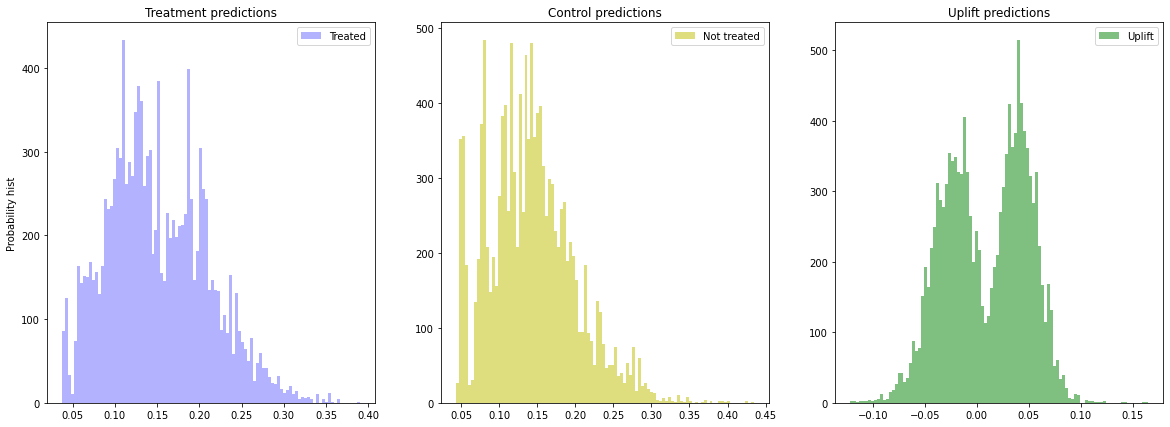

In [67]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_)

In [68]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.204624,0.170045
2,TwoModels,0.046445,0.051740
0,SoloModel,0.014508,0.018855


Дерево решений

In [69]:
df = pd.concat([df.drop(columns='zip_code', axis=1), pd.get_dummies(df['zip_code'], prefix='zip_code')], 1)
df = pd.concat([df.drop(columns='channel', axis=1), pd.get_dummies(df['channel'], prefix='channel')], 1)
df

C:\Users\C559~1\AppData\Local\Temp/ipykernel_8928/471580122.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([df.drop(columns='zip_code', axis=1), pd.get_dummies(df['zip_code'], prefix='zip_code')], 1)
C:\Users\C559~1\AppData\Local\Temp/ipykernel_8928/471580122.py:2: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  df = pd.concat([df.drop(columns='channel', axis=1), pd.get_dummies(df['channel'], prefix='channel')], 1)


,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,0,0,1,0,0,0,0,1
4,2,45.34,1,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,0,0,0,0,0,1,0,0,1
63996,5,38.91,0,1,1,0,0,0,0,1,0,1,0
63997,6,29.99,1,0,1,0,0,0,0,1,0,1,0
63998,1,552.94,1,0,1,1,0,0,1,0,1,0,0


In [1]:
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

ModuleNotFoundError: No module named 'causalml'

In [1]:
!pip install causalml

  Using cached causalml-0.13.0.tar.gz (535 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [67 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.8
  creating build\lib.win-amd64-3.8\causalml
  copying causalml\features.py -> build\lib.win-amd64-3.8\causalml
  copying causalml\match.py -> build\lib.win-amd64-3.8\causalml
  copying causalml\propensity.py -> build\lib.win-amd64-3.8\causalml
  copying causalml\__init__.py -> build\lib.win-amd64-3.8\causalml
  creating build\lib.win-amd64-3.8\causalml\dataset
  copying causalml\dataset\classification.py -> build\lib.win-amd64-3.8\causalml\dataset
  copying causalml\dataset\regression.py -> build\lib.win-amd64-3.8\causalml\dataset
  copying causalml\dataset\synthetic.py -> build\lib.win-amd64-3.8\causalml\dataset
  copying causalml\dataset\__init__.py -> build\lib.win-amd64-3.8\causalml\dataset
  creating build\lib.win-amd64-3.8\causalml\featu

  Running setup.py clean for causalml
Failed to build causalml
  Running setup.py install for causalml: started
  Running setup.py install for causalml: finished with status 'error'


causalml я не смогла установить данную библиотеку, поэтому последний пункт не сделала